In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pickle
import json

In [2]:
data_set = pickle.load(open('bnb.p', 'rb'))
para = json.loads(open('para.json', 'r').read())

In [3]:
def get_key(index):
    return list(para['label_dictionary'].keys())[list(para['label_dictionary'].values()).index(index)]

def batch_index(l, batch_size):
    a = l // batch_size
    b = np.random.permutation(l)
    c = np.split(b, [(i+1) * batch_size for i in range(a)])
    if len(c[-1]) == 0:
        c = c[:-1]
    return c

def cal_acc(pred_result_list):
    return sum(pred_result_list) / len(pred_result_list)

In [4]:
import tensorflow as tf

_, w, h, c = data_set['train_image'].shape
num_of_class = len(np.unique(data_set['train_label'])) # train_label에 등장하는 class의 개수로 전체 클래스의 개수를 추정
log = {
    'loss' : [],
    'train_acc' : [],
    'test_acc' : []
}

tf.reset_default_graph()

learning_rate = 0.001
n_epochs = 25
batch_size = 16

#l_rate = para['learning_rate']
#num_of_iteration = para['num_of_iteration']
#print_frequency = para['print_frequency']

X = tf.placeholder(tf.float32, [None, w, h, c])
y = tf.placeholder(tf.int32, [None, 1])
Y_one_hot = tf.one_hot(y, num_of_class)
Y_one_hot = tf.reshape(Y_one_hot, [-1, num_of_class])

W1 = tf.Variable(tf.random_normal([3, 3, 3, 32], stddev=0.01))
L1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01)) 
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

L2_flat = tf.reshape(L2, [-1, 8 * 8 * 64]) 

W3 = tf.get_variable("W3", shape=[8 * 8 * 64, 2], initializer=tf.contrib.layers.xavier_initializer())
b = tf.Variable(tf.random_normal([2]))
logits = tf.matmul(L2_flat, W3) + b

xentropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_one_hot)
loss = tf.reduce_mean(xentropy, name="loss")

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

correct = tf.equal(tf.argmax(logits, 1), tf.argmax(Y_one_hot, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

sess = tf.Session()

sess.run(init)

test_y_batch = np.reshape(data_set['test_label'], (-1,1))

for epoch in range(n_epochs):
    for ind in batch_index(len(data_set['train_image']), batch_size):
        X_batch, y_batch = data_set['train_image'][ind], np.reshape(data_set['train_label'][ind], (-1,1))
        
        _, train_correct, loss1 = sess.run([training_op, correct, loss], feed_dict={X: X_batch, y: y_batch})
        log['train_acc'].append(cal_acc(train_correct))
        log['loss'].append(loss1)
        
        test_correct = sess.run(correct, feed_dict={X: data_set['test_image'], y: test_y_batch})
        log['test_acc'].append(cal_acc(test_correct))
        
    acc_train = sess.run(correct, feed_dict={X: X_batch, y: y_batch})
    acc_test = sess.run(correct, feed_dict={X: data_set['test_image'], y: test_y_batch})
    print("Epoch:", epoch, "Train accuracy:", sum(acc_train) / len(acc_train), "Test accuracy:", sum(acc_test) / len(acc_test))

Epoch: 0 Train accuracy: 0.5625 Test accuracy: 0.595
Epoch: 1 Train accuracy: 0.6875 Test accuracy: 0.745
Epoch: 2 Train accuracy: 0.8125 Test accuracy: 0.8
Epoch: 3 Train accuracy: 1.0 Test accuracy: 0.76
Epoch: 4 Train accuracy: 1.0 Test accuracy: 0.83
Epoch: 5 Train accuracy: 0.9375 Test accuracy: 0.855
Epoch: 6 Train accuracy: 1.0 Test accuracy: 0.875
Epoch: 7 Train accuracy: 1.0 Test accuracy: 0.845
Epoch: 8 Train accuracy: 1.0 Test accuracy: 0.885
Epoch: 9 Train accuracy: 1.0 Test accuracy: 0.88
Epoch: 10 Train accuracy: 1.0 Test accuracy: 0.905
Epoch: 11 Train accuracy: 1.0 Test accuracy: 0.865
Epoch: 12 Train accuracy: 1.0 Test accuracy: 0.9
Epoch: 13 Train accuracy: 1.0 Test accuracy: 0.885
Epoch: 14 Train accuracy: 1.0 Test accuracy: 0.89
Epoch: 15 Train accuracy: 1.0 Test accuracy: 0.89
Epoch: 16 Train accuracy: 1.0 Test accuracy: 0.875
Epoch: 17 Train accuracy: 1.0 Test accuracy: 0.875
Epoch: 18 Train accuracy: 1.0 Test accuracy: 0.86
Epoch: 19 Train accuracy: 1.0 Test accu

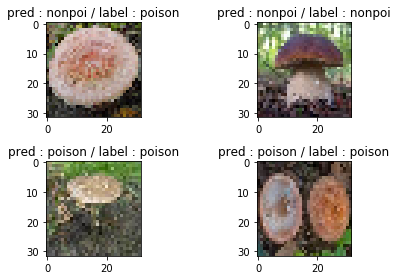

In [5]:
%matplotlib inline
index_list = np.random.randint(200, size = 4)
for i in range(4):
    ind = index_list[i]
    test_pred = sess.run(logits, feed_dict={X: data_set['test_image'][ind].reshape((-1,32,32,3))})
    pred, label = get_key(np.argmax(test_pred)), get_key(int(data_set['test_label'][ind]))
    plt.subplot(221+i)
    plt.imshow(data_set['test_image'][ind]/255)
    plt.title("pred : " + pred[:6] + " / label : " + label[:6])
plt.tight_layout()

In [6]:
sess.close()

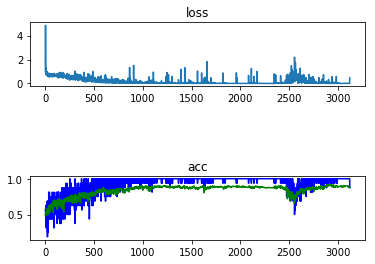

In [7]:
l = len(log['loss'])
plt.subplot(311)
plt.plot(range(l), log['loss'])
plt.title('loss')
plt.subplot(313)
plt.plot(range(l), log['train_acc'], 'b', range(l), log['test_acc'], 'g')
plt.title('acc')
plt.show()